In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib.pyplot as plt
import proyecciones as pro
import time

# Parámetros

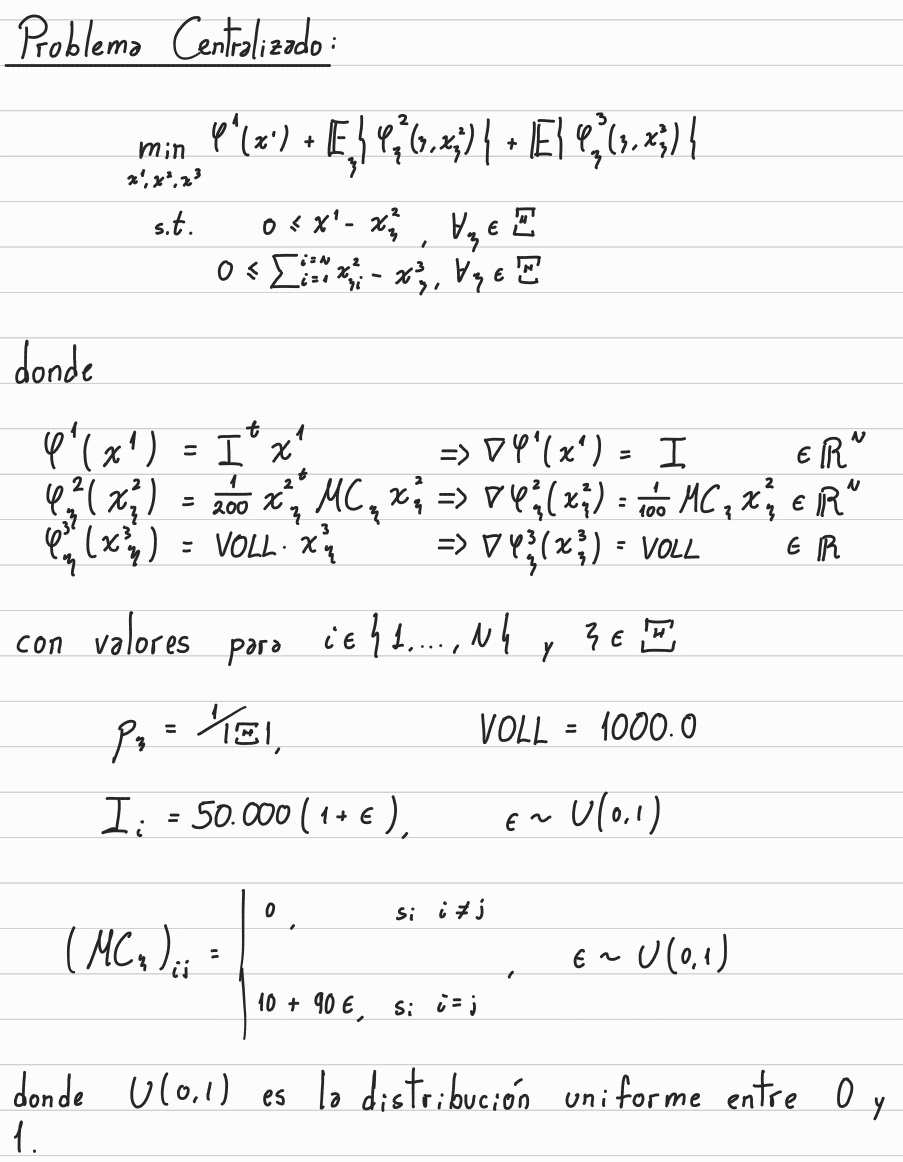

In [2]:
# Seteamos los parámetros:
N, M = 3, 5  # Son 2 tecnologías, 10 escenarios.

if 0:
    r=1
else:
    r=0

# Probabilidades:
if r==0:
    Sigma = np.random.random((1,M))
    Sigma /= Sigma.sum()
else:
    Sigma = np.ones((1,M)) 
    Sigma /= Sigma.shape[1] 

# Parámetros funciones:
I    = 50 * (np.ones((N, 1)) + r*np.random.rand(N,1))
MC   = np.array([np.diag(1000*np.ones(N)+r*90*np.random.rand(N)) for m in range(M)])
VOLL = 10000.0
D    = 1000.0*(np.ones((1,M))+r*np.random.rand(1,M))

e1  = VOLL*1.1
e2  = VOLL*1.1
e31 = VOLL*1.1
e32 = VOLL*1.1

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))
    

frobenius_norm_of_MC = (e1+e2)*N*0.5+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()

# variables
x1     = np.random.randint(0,10, size=(N, 1))+0.0
x1_NA  = np.random.randint(0,10, size=(N, M))+0.0
x2     = np.random.randint(0,10, size=(N, M))+0.0
x3     = np.random.randint(0,10, size=(1, M))+0.0

y1     = np.random.randint(0,10, size=(N, M))+0.0
y2     = np.random.randint(0,10, size=(N, M))+0.0
y3     = np.random.randint(0,10, size=(1, M))+0.0

z1     = np.random.randint(0,10, size=(N, M))+0.0
z2     = np.random.randint(0,10, size=(N, M))+0.0
z3     = np.random.randint(0,10, size=(1, M))+0.0


# Consideremos funciones Phi_i de la forma:
# 
#     Phi_i(x_i) = 1/2 x_i.T*Q_i*x_i + B_i.T * x_i + C_i + término de penalizacion
#


def Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, C_1 = 0.0, e1 = e1):
    return 0.5*np.einsum('ij,ji -> i', x1.T,np.dot(Q_1,x1))[:,np.newaxis]+np.dot(x1.T, B_1)+C_1 + e1/2*LA.norm(np.maximum(-x1.flatten(),0))**2

def Phi_2_xi(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), C_2 = np.zeros((M, 1))):
    return 0.5*np.einsum('ij,ji -> i', x2.T, np.einsum('ijk,ki -> ji', Q_2, x2))[:,np.newaxis]+np.einsum('ij,ji->i',x2.T,B_2)[:,np.newaxis]+C_2 + e2/2*LA.norm(np.maximum(-x2.flatten(),0))**2
    
def Phi_3_xi(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), C_3 = -VOLL*D ):
        return (0.5*x3*Q_3*x3+B_3*x3+C_3).T + e31/2*LA.norm(np.maximum(-x3.flatten(),0))**2 + e32/2*LA.norm(np.maximum((D-x3).flatten(),0))**2


def objective_function(x1, x2, x3, P = Sigma, NA = True):
    # 
    # NA = True, cumple la funcion que si se impuso 
    #      la condición de no anticipatividad para x1
    #      entonces, Phi_1(x1).shape == (M,1)
    if NA:
        return np.dot(P, Phi_1(x1) +Phi_2_xi(x2)+Phi_3_xi(x3))
    else:
        return Phi_1(x1)+ np.dot(P, Phi_2_xi(x2)+Phi_3_xi(x3))

    # me queda e1 * max{0,-x1}
def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
    return np.dot(Q_1,x1)+B_1 - e1*np.dot(np.identity(N),np.maximum(-x1,0))
    # me queda e2 * max{0,-x2}
def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):
    
    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2 - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))
    # me queda e31 * max{0,-x3} &  e32 * max{0,-D+x3}
def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 - e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))
    
def Grad_Phi(x1,x2,x3, P = Sigma):
        return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

In [3]:
print("Variables:")
print("x1:")
print(x1)
print("x1_NA:")
print(x1_NA)
print("x2:")
print(x2)
print("x3:")
print(x3)
print()
print()
print("Parámetros:")
print("Sigma:")
print(Sigma)
print("I:")
print(I)
print("MC:")
print(MC)
print("VOLL:")
print(VOLL)
print("D:")
print(D)
print()
print()
print("Funciones Objetivos:")
print("Phi_1(x1):")
print(Phi_1(x1))
print("Phi_1(x1_NA):")
print(Phi_1(x1_NA))
print("Phi_2_xi(x2):")
print(Phi_2_xi(x2))
print("Phi_3_xi(x3):")
print(Phi_3_xi(x3))
print()
print()
print("Phi_1(x1)+lE_xi{Phi_2_xi(x2)}+lE_xi{Phi_3_xi(x3)}")
print(objective_function(x1,x2,x3, NA = False))
print("Phi_1(x1_NA)+lE_xi{Phi_2_xi(x2)}+lE_xi{Phi_3_xi(x3)}")
print(objective_function(x1_NA,x2,x3))
print()
print()
print("Gradientes:")
print("Grad_Phi_1(x1):")
print(Grad_Phi_1(x1))
print("Grad_Phi_1(x1_NA):")
print(Grad_Phi_1(x1_NA))
print("Grad_Phi_2_xi(x2):")
print(Grad_Phi_2(x2))
print("Grad_Phi_3_xi(x3):")
print(Grad_Phi_3(x3))
print("Grad_Phi(x1,x2,x3)")
print(Grad_Phi(x1,x2,x3))
print("Grad_Phi(x1_NA,x2,x3)")
print(Grad_Phi(x1_NA,x2,x3))

Variables:
x1:
[[3.]
 [9.]
 [1.]]
x1_NA:
[[6. 4. 3. 6. 3.]
 [7. 0. 8. 2. 9.]
 [2. 6. 2. 0. 6.]]
x2:
[[4. 1. 6. 0. 1.]
 [0. 1. 6. 6. 6.]
 [4. 4. 8. 2. 6.]]
x3:
[[2. 2. 7. 4. 1.]]


Parámetros:
Sigma:
[[0.12625354 0.20229459 0.18931384 0.23932273 0.2428153 ]]
I:
[[50.]
 [50.]
 [50.]]
MC:
[[[1000.    0.    0.]
  [   0. 1000.    0.]
  [   0.    0. 1000.]]

 [[1000.    0.    0.]
  [   0. 1000.    0.]
  [   0.    0. 1000.]]

 [[1000.    0.    0.]
  [   0. 1000.    0.]
  [   0.    0. 1000.]]

 [[1000.    0.    0.]
  [   0. 1000.    0.]
  [   0.    0. 1000.]]

 [[1000.    0.    0.]
  [   0. 1000.    0.]
  [   0.    0. 1000.]]]
VOLL:
10000.0
D:
[[1000. 1000. 1000. 1000. 1000.]]


Funciones Objetivos:
Phi_1(x1):
[[650.]]
Phi_1(x1_NA):
[[750.]
 [500.]
 [650.]
 [400.]
 [900.]]
Phi_2_xi(x2):
[[160.]
 [ 90.]
 [680.]
 [200.]
 [365.]]
Phi_3_xi(x3):
[[2.7314427e+10]
 [2.7314427e+10]
 [2.7314477e+10]
 [2.7314447e+10]
 [2.7314417e+10]]


Phi_1(x1)+lE_xi{Phi_2_xi(x2)}+lE_xi{Phi_3_xi(x3)}
[[2.73144398e+10]

# Davis_Yin

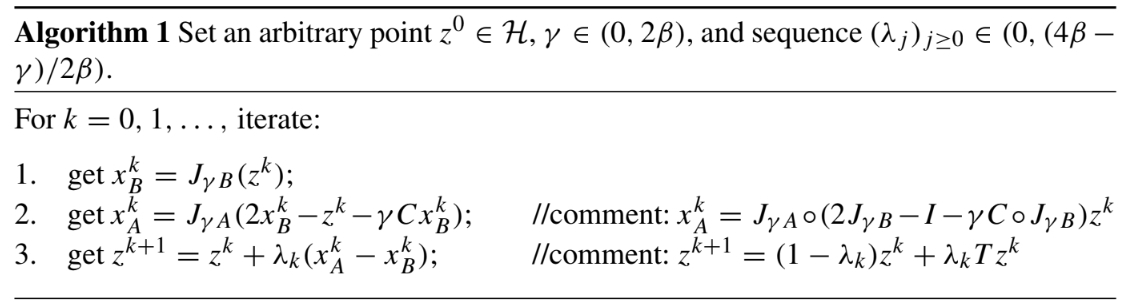

Nuestro objetivo será implementar el algoritmo de davis-yin c:

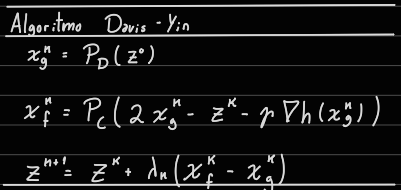

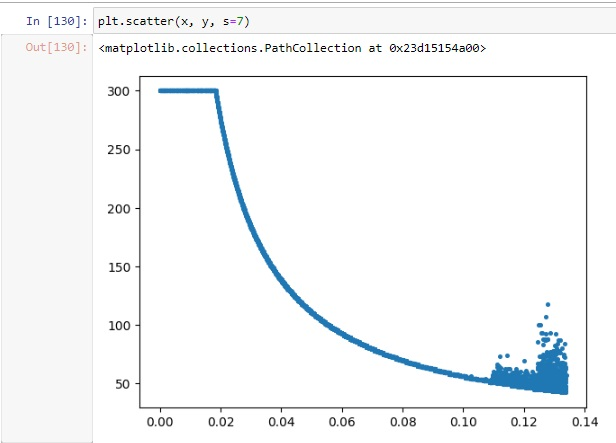

In [26]:
def Davis_Yin_iteration(z1 : np.array, z2: np.array, z3: np.array, gradient_of_h, gamma, lambda_k, Demanda):
    """
        Input:
            - z1: np.array(1xN)   decision variable
            - z2: np.array(NxM)   decision variable
            - z3: np.array(Mx1)   decision variable
            - gradient_of_h: function has contain the gradien of the cost function
            - lambda_k: number between 0 and (4*beta - gamma)/(2*beta) where beta is 
                        the lipschitz constan of the gradien of h.
        Output:
            - tuple np.array, np.array, np.array
        Work:
            The function ompute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """
    
    xg_1, xg_2 = pro.P_D(z1, z2)
    xg_3 = z3
    
    grad_x1, grad_x2, grad_x3 = gradient_of_h(xg_1, xg_2, xg_3)
    
    xf_1       =                 2*xg_1 - z1 - gamma*grad_x1
    xf_2, xf_3 = pro.P_C_demanda(2*xg_2 - z2 - gamma*grad_x2,\
                                 2*xg_3 - z3 - gamma*grad_x3  , Demanda)
    
    z1 = z1 + lambda_k*(xf_1 - xg_1)
    z2 = z2 + lambda_k*(xf_2 - xg_2)
    z3 = z3 + lambda_k*(xf_3 - xg_3)
    
    return (xg_1, xg_2, xg_3), (xf_1, xf_2, xf_3), (z1, z2, z3)

In [27]:
def Davis_Yin(N,M, frobenius_norm_of_MC, cost_function, number_iteration, Demanda):
    
    # Punto inicial
    z1  = np.zeros((N, 1))
    z2  = np.zeros((N, M))
    z3  = np.zeros((1, M))
    
    # Hiper-parámetros
    beta = frobenius_norm_of_MC**(-1)               # Dependes of cost_function
    gamma = 2*beta*(0.75 + 0.5*np.random.random(1)) # Uniform distribution - U(2*beta*0.75, 2*beta)
    lambda_k = 1                                    # lambda_k in (0,(4*beta - gamma)/(2*beta = 1.75))
    
    Loss = 1

    a= "factible"
    b= "factible"
    
    xg_list = []
    
    for k in range(number_iteration):
              
        (xg1_k, xg2_k, xg3_k), (xf1_k, xf2_k, xf3_k), (z1, z2, z3) = Davis_Yin_iteration(z1, z2, z3, cost_function, gamma, lambda_k, Demanda)
        
        
        if (xg1_k <= xg2_k).all():
            a = "factible"
        else:
            a= "infactible"
            
        if (xg2_k.sum(axis=0) + xg3_k >= Demanda).all():
            b = "factible"
        else:
            b= "infactible"
            
        if ( a == "infactible" or b == "infactible"):
            xg_factible = "infactible"
        else:
            xg_factible = "factible"
        
        xg_list.append( ((xg1_k, xg2_k, xg3_k), xg_factible) )
        
    return xg_list

In [35]:
# Seteamos los parámetros:
N, M = 3, 5  # Son 2 tecnologías, 10 escenarios.

# Probabilidades:

Sigma = np.ones((1,M))
Sigma /= Sigma.sum()
    
# Parámetros funciones:
I    = 50 * np.ones((N, 1))
MC   = np.array([np.diag(1000*np.ones(N)) for m in range(M)])
VOLL = 10000.0
D    = 1000.0*np.ones((1,M))

e1  = VOLL*1.1
e2  = VOLL*1.1
e31 = VOLL*1.1
e32 = VOLL*1.1

Q1, B1 = np.zeros((N,N)), I
Q2, B2 = 0.01*MC, np.zeros((N,M))
Q3, B3 = np.zeros((1,M)), VOLL*np.ones((1,M))
    

frobenius_norm_of_MC = (e1+e2)*N*0.5+e31+e32+np.array([LA.norm(np.einsum('i,ikl->ikl',Sigma[0],0.01*MC)[xi], 'fro') for xi in range(M)]).sum()

def Grad_Phi_1(x1, Q_1 = np.zeros((N,N)), B_1 = I, e1 = e1, N = N):
    return np.dot(Q_1,x1)+B_1 - e1*np.dot(np.identity(N),np.maximum(-x1,0))
    # me queda e2 * max{0,-x2}
def Grad_Phi_2(x2, Q_2 = 0.01*MC, B_2 = np.zeros((N,M)), e2 = e2, N = N, M = M):
    
    return np.einsum('ijk,ki->ji', Q_2, x2)+B_2 - e2*np.einsum('ijk,ki->ji', np.array([np.diag(np.ones(N)) for m in range(M)]), np.maximum(-x2,0))
    # me queda e31 * max{0,-x3} &  e32 * max{0,-D+x3}
def Grad_Phi_3(x3, Q_3 = np.zeros((1,M)), B_3 = VOLL*np.ones((1,M)), D=D, e31=e31, e32= e32, M = M):
    return Q_3*x3+B_3 - e31*np.dot(np.maximum(-x3,0),np.identity(M)) - e32*np.dot(np.maximum(-D+x3,0),np.identity(M))
    
def Grad_Phi(x1,x2,x3, P = Sigma):
        return Grad_Phi_1(x1), P*Grad_Phi_2(x2), P*Grad_Phi_3(x3)

In [43]:
lista_larga = Davis_Yin(N,M, frobenius_norm_of_MC, Grad_Phi, 300000, D)

In [45]:
lista_larga[-1]

((array([[333.53377764],
         [333.53377764],
         [333.53377764]]),
  array([[333.53377764, 333.53377764, 333.53377764, 333.53377764,
          333.53377764],
         [333.53377764, 333.53377764, 333.53377764, 333.53377764,
          333.53377764],
         [333.53377764, 333.53377764, 333.53377764, 333.53377764,
          333.53377764]]),
  array([[-0.60133293, -0.60133293, -0.60133293, -0.60133293, -0.60133293]])),
 'factible')

In [32]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib.pyplot as plt
import proyecciones as pro
import time


def Davis_Yin_iteration(z1 : np.array, z2: np.array, z3: np.array, gradient_of_h, gamma, lambda_k, Demanda):
    """
        Input:
            - z1: np.array(1xN)   decision variable
            - z2: np.array(NxM)   decision variable
            - z3: np.array(Mx1)   decision variable
            - gradient_of_h: function has contain the gradien of the cost function
            - lambda_k: number between 0 and (4*beta - gamma)/(2*beta) where beta is 
                        the lipschitz constan of the gradien of h.
        Output:
            - tuple np.array, np.array, np.array
        Work:
            The function ompute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """
    
    xg_1, xg_2 = pro.P_D(z1, z2)
    xg_3 = z3
    
    grad_x1, grad_x2, grad_x3 = gradient_of_h(xg_1, xg_2, xg_3)
    
    xf_1       =                 2*xg_1 - z1 - gamma*grad_x1
    xf_2, xf_3 = pro.P_C_demanda(2*xg_2 - z2 - gamma*grad_x2,\
                                 2*xg_3 - z3 - gamma*grad_x3  , Demanda)
    
    z1 = z1 + lambda_k*(xf_1 - xg_1)
    z2 = z2 + lambda_k*(xf_2 - xg_2)
    z3 = z3 + lambda_k*(xf_3 - xg_3)
    
    return (xg_1, xg_2, xg_3), (xf_1, xf_2, xf_3), (z1, z2, z3)



def Davis_Yin(N,M, frobenius_norm_of_MC, cost_function, number_iteration, Demanda):
    
    # Punto inicial
    z1  = np.zeros((N, 1))
    z2  = np.zeros((N, M))
    z3  = np.zeros((1, M))
    
    # Hiper-parámetros
    beta = frobenius_norm_of_MC**(-1)               # Dependes of cost_function
    gamma = 2*beta*(0.75 + 0.5*np.random.random(1)) # Uniform distribution - U(2*beta*0.75, 2*beta)
    lambda_k = 1                                    # lambda_k in (0,(4*beta - gamma)/(2*beta = 1.75))

    a= "factible"
    b= "factible"
    
    xg_list = []
    
    for k in range(number_iteration):
              
        (xg1_k, xg2_k, xg3_k), (xf1_k, xf2_k, xf3_k), (z1_k, z2_k, z3_k) = Davis_Yin_iteration(z1, z2, z3, cost_function, gamma, lambda_k, Demanda)
        
        z1 = z1_k
        z2 = z2_k
        z3 = z3_k
        
        if (xg1_k <= xg2_k).all():
            a = "factible"
        else:
            a= "infactible"
            
        if (xg2_k.sum(axis=0) + xg3_k >= Demanda).all():
            b = "factible"
        else:
            b= "infactible"
            
        if ( a == "infactible" or b == "infactible"):
            xg_factible = "infactible"
        else:
            xg_factible = "factible"
        
        xg_list.append( ((xg1_k, xg2_k, xg3_k), xg_factible) )
        
    return xg_list

# ADMM

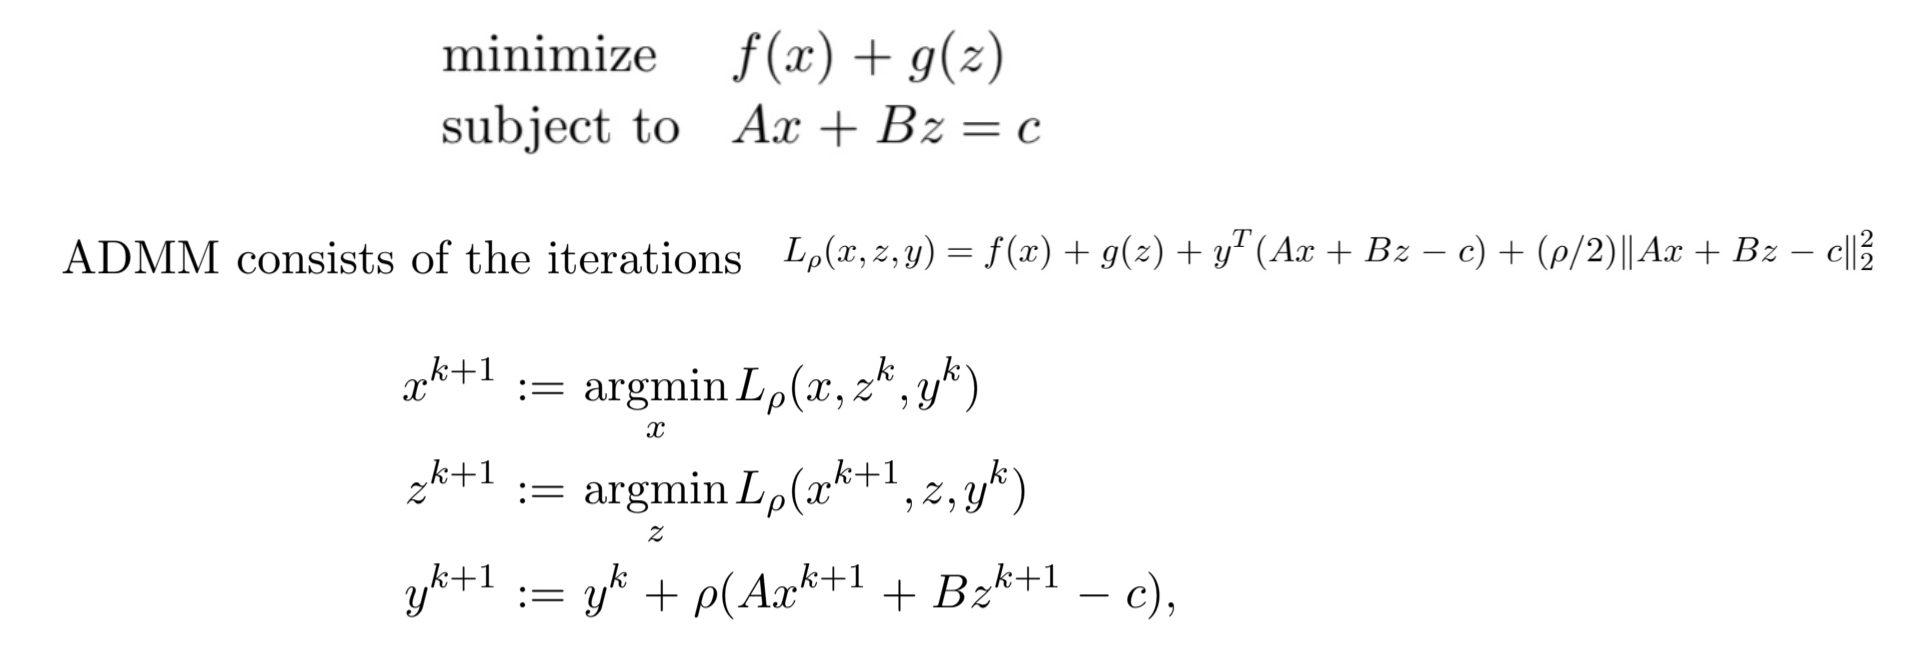

Ahora, estro objetivo será implementar el algoritmo ADMM, esto es:

In [ ]:
def ADMM_iteration(decision, state, dual, phi_z1, phi_z2, phi_z3, P=Sigma, D=D, r=1e-3,e1=e1, e2=e2, e31=e31, e32=e32):
    """
        Input:
            - decision = (x1,x2,x3): (np.array(NxM), np.array(NxM), np.array(Mx1) decision variable
            - state    = (z1, z2): (np.array(Mx1), np.array(NxM)) state variables
            - dual     = (lambda_1, lambda_2, lambda_3) (np.array(NxM), np.array(NxM), np.array(Mx1)) dual update variable
            
              Now will go the gradient of the objective functions, in this case we
              will assume there are linear, so their value is fix and a vector.
              
            - phi_z1: np.array(N) function has contain the gradient of the cost function over z1 variable 
            - phi_z2: np.array(NxM) function has contain the gradient of the cost function over z2 variable
            - phi_z3: np.array(M) function has contain the gradient of the cost function over zm3 variable
            
            - prob: np.array(M) np.array that contain the probability of each scenario
            
            - s,t,r: floats that are the augmented term of lagrangian. 1e-3 by default.
        Output:
            - tuple np.array, np.array, np.array
        Work:
            The function compute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """
    Q1, B1 = phi_z1
    Q2, B2 = phi_z2
    Q3, B3 = phi_z3
    
    x1, x2, x3 = decision
    z1, z2, z3 = state    #Unpackage the variables
    y1, y2, y3 = dual
    
    N, M = x1.shape
    
  
    s1  = np.sign(z1-y1-(r**-1)*B1)
    s2  = np.sign(z2-y2-(r**-1)*B2)
    s31 = np.sign(z3-y3-(r**-1)*B3)
    s32 = np.sign((r**-1)*(Q3 + r)*D - (z3-y3-(r**-1)*B3))
    
    
    
    scale_factor_1 = r/(np.tile(np.diag(Q1),(M,1)).T + r + np.maximum(-s1*e1,0))
    scale_factor_2 = r/(np.diagonal(Q2, axis1=1, axis2=2).transpose() + r + np.maximum(-s2*e2,0))
    scale_factor_3 = r/(Q3+r)


    c1 = scale_factor_1 * (z1-y1-(r**-1)*B1)
    c2 = scale_factor_2 * (z2-y2-(r**-1)*B2)
    c3 = scale_factor_3 * (z3-y3-(r**-1)*B3)
    
    
    tk = (c2-c1+np.maximum(c1-c2,0))/((scale_factor_1+scale_factor_2)/r)
    
    
    # Start algorithm
    x1_k = c1 + (r**-1) * scale_factor_1 * tk
    x2_k = c2 - (r**-1) * scale_factor_2 * tk
    x3_k = ((Q3+r)*c3+np.maximum(-s32*e32,0)*D)/(Q3+r+np.maximum(-s31*e31,0)+np.maximum(-s32*e32,0))
    
    z1_k               = pro.P_N( y1 + x1_k, P)
    z2_k,z3_k, lambda1 = pro.P_C_demanda(y2 + x2_k, y3 + x3_k, D)
    
    y1_k = y1 + x1_k - z1_k
    y2_k = y2 + x2_k - z2_k
    y3_k = y3 + x3_k - z3_k
    
    return (x1_k, x2_k, x3_k), (z1_k, z2_k, z3_k), (y1_k, y2_k, y3_k), lambda1

In [ ]:
%timeit ADMM_iteration((x1_NA, x2, x3), (z1, z2, z3), (y1, y2, y3), (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D)

ADMM_iteration((x1_NA, x2, x3), (z1, z2, z3), (y1, y2, y3), (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D)

In [ ]:
def ADMM(Number_iteration, proba = Sigma, D = D):
    
    x1     = np.zeros((N, M))
    x2     = np.zeros((N, M))
    x3     = np.zeros((1, M))
    
    z1     = np.zeros((N, 1))
    z2     = np.zeros((N, M))
    z3     = np.zeros((1, M))
    
    y1     = np.zeros((N, 1))
    y2     = np.zeros((N, M))
    y3     = np.zeros((1, M))

    r=0.5e2*0.90741
    
    k=0
    Loss = 1000
    
    a= "factible"
    b= "factible"
    
    error_list = []
    
    while (Loss >= 1e-5 or ( a == "infactible" or b=="infactible")) and k < Number_iteration:
        #lambda_k = ((4*beta - gamma)/(2*beta))*np.random.random(1)
        if k == Number_iteration:
            break
        
        (x1_k, x2_k, x3_k), (z1_k, z2_k,z3_k), (y1_k, y2_k, y3_k), lambda1 = ADMM_iteration((x1, x2, x3), (z1, z2, z3), (y1, y2, y3), (Q1,B1), (Q2,B2), (Q3,B3), Sigma, D, r)
        
        Loss = LA.norm(x1_k - x1)**2 + LA.norm(x2_k - x2)**2 + LA.norm(x3_k - x3)**2
        Loss = Loss/(LA.norm(x1_k)**2 + LA.norm(x2_k)**2 + LA.norm(x3_k)**2)*100
        
        error_list.append(Loss)
        
        a= "infactible"
        b= "infactible"
        
        x1 = x1_k
        x2 = x2_k
        x3 = x3_k
        
        z1 = z1_k
        z2 = z2_k
        z3 = z3_k
        
        y1 = y1_k
        y2 = y2_k
        y3 = y3_k
        
        if (x1 <= x2).all():
            a = "factible"
        else:
            a= "infactible"
            
        if (x2.sum(axis=0) + x3 >= D).all():
            b = "factible"
        else:
            b= "infactible"
            
        if (x1 == np.roll(x1, 1, axis=1)).all():
            d = "NA_factible"
        else:
            d = "NA_infactible"

        print("Iteration:",k ," Loss:", Loss, "Factible:",a,b,d)
        
        
        
        k+=1
        
    return (x1, x2, x3), (z1, z2, z3), (y1, y2, y3), lambda1, error_list, r

In [ ]:
(x1, x2, x3), (z1, z2, z3), (y1, y2, y3), lambda1, error_list_ADMM, r = ADMM(3e6)

In [ ]:
plt.scatter(range(len(error_list_ADMM)-2), error_list_ADMM[2:], s=10)
plt.show()

In [ ]:
print(x1, x2, x3)
print()
print(z1, z2, z3)
print()
print(y1, y2, y3)
print()
print(lambda1/r)

# Briceno_Arias

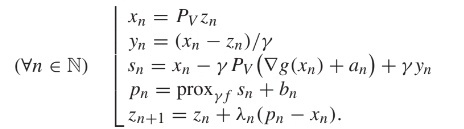

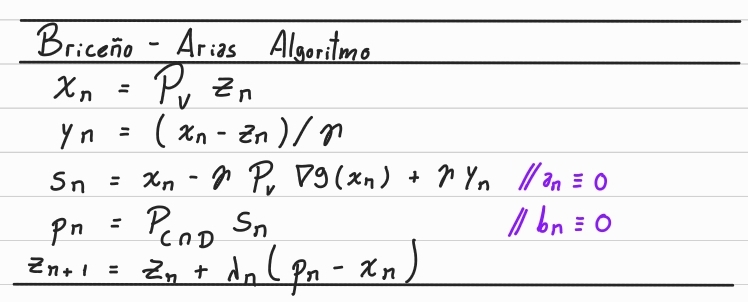

In [11]:
def Briceno_Arias_iteration(z1, z2, z2_copy, z3, gradient_of_g, P, gamma, lambda_n, D = D):
    """
        Input:
            - z1     : np.array(NxM) decision variable
            - z2     : np.array(NxM) decision variable
            - z2_copy: np.array(NxM) decision variable
            - z3     : np.array(Mx1) decision variable
            - gradient_of_g: function has contain the gradien of the cost function
            - lambda_k: number between 0 and (4*beta - gamma)/(2*beta) where beta is 
                        the lipschitz constan of the gradien of h.
        Output:
            - tuple np.array, np.array, np.array, np.array
        Work:
            The function ompute one iteration over the Davis_Yin_algorithm
            with prior knowledge of gamma.
    """    
    
    # First step, xn = Pv zn
    x1, x2, x2_copy = pro.P_N1(z1, z2, z2_copy, P)
    x3 = z3
    
    # Unpackage of gradient
    g1, g2     , g3 = gradient_of_g(x1, x2,      x3, P)
    _ , g2_copy, _  = gradient_of_g(x1, x2_copy, x3, P)
    
    # Segundo step, yn = (xn-zn)/gamma
    y1      = (x1     - z1     )*(gamma**-1)
    y2      = (x2     - z2     )*(gamma**-1)
    y2_copy = (x2_copy- z2_copy)*(gamma**-1)
    y3      = (x3     - z3     )*(gamma**-1)
    
    # Third step, sn = xn - gamma * Pv ( gradient_of_g ) + gamma * yn
    (s1_aux, s2_aux, s2_copy_aux) = pro.P_N1(g1, g2, g2_copy, P)

    s1      = x1      - gamma*(s1_aux - y1)
    s2      = x2      - gamma*(s2_aux - y2)
    s2_copy = x2_copy - gamma*(s2_copy_aux - y2_copy)
    s3      = x3      - gamma*(g3 - y3)
    
    # Fourth step, pn = Pc\cap D sn
    (p1, p2, lambda1),(p2_copy, p3, lambda2) = pro.P_CinterD_demanda(s1, s2, s2_copy, s3, D)    

    
    # Last step, zn+1 = zn + lambdan* (pn - xn)
    z1_k      = z1      + lambda_n * (p1 - x1)
    z2_k      = z2      + lambda_n * (p2 - x2)
    z2_copy_k = z2_copy + lambda_n * (p2_copy - x2_copy)
    z3_k      = z3      + lambda_n * (p3 - x3)
    
    return (z1_k, z2_k, z2_copy_k, z3_k), (y1, y2, y2_copy, y3), (x1, x2, x2_copy, x3), (lambda1, lambda2)

In [12]:
#%timeit Briceno_Arias_iteration(x1_NA,x2,x2, x3, Grad_Phi, Sigma, 1e-3, 1e-3)
#Briceno_Arias_iteration(x1_NA,x2,x2, x3, Grad_Phi, Sigma, 1e-3, 1e-3)

In [13]:
def Briceno_Arias(N,M, Grad_Phi = Grad_Phi, P=Sigma, gamma=1e-3, lambdan=1e-3, number_iteration = 3e2 , D=D):

    z1      = np.random.random((N,M))
    z2      = np.random.random((N,M))
    z2_copy = np.random.random((N,M))
    z3      = np.random.random((1,M))
    
    x1_k      = np.zeros((N,M))
    x2_k      = np.zeros((N,M))
    x2_copy_k = np.zeros((N,M))
    x3_k      = np.zeros((1,M))
    
    N, M = z2.shape
    
    beta = frobenius_norm_of_MC**(-1)
    gamma = 2*beta*np.random.random(1)
    #gamma = 2*beta*(0.75 + 0.25*np.random.random(1))
    alpha = np.maximum(2/3, (2*gamma)/(gamma+2*beta))
    
    print("Beta:",beta)
    print("Gamma:",gamma)
    print("alpha:", alpha)
    
    k=0
    Loss = 1000    
    error_list = []
    lambda_list= []
    
    while (Loss >= 1e-10 or ( a == "D_infactible" or b=="C_infactible" or c == "Copy_infactible" or d== "NonAnt_infactible")) and k < number_iteration:
        
        #lambda_n = (1/alpha)*np.random.random(1)/(k**0.25+2)
        #lambda_n = (1/alpha)
        #lambda_n = 1
        #lambda_n = (1/alpha)*np.random.random(1)
        lambda_n = 0.95*(1/alpha)*np.random.random(1)+1
        #lambda_n =(1/alpha)*(0.75 + 0.5*np.random.random(1))
        
        (z1_k, z2_k, z2_copy_k, z3_k),(y1, y2, y2_copy, y3), (x1, x2, x2_copy, x3), (lambda1, lambda2) = Briceno_Arias_iteration(z1,z2,z2_copy, z3, Grad_Phi, Sigma, gamma, lambda_n)
        
        Loss = LA.norm(x1_k - x1)**2 + LA.norm(x2_k - x2)**2 + LA.norm(x3_k - x3)**2
        Loss = Loss/(LA.norm(x1_k)**2 + LA.norm(x2_k)**2 + LA.norm(x3_k)**2)*100
        
        a = "D_infactible"
        b = "C_infactible"
        c = "Copy_infactible"
        d = "NonAnt_infactible"
        
        error_list.append(Loss)
        
        if (x2 <= x1).all():
            a = "D_factible"
        if (x2_copy.sum(axis=0) + x3 >= D).all():
            b = "C_factible"
        if (x2_copy == x2).all():
            c = "Copy_factible"
        if (x1 == np.roll(x1, 1, axis=1)).all():
            d = "NonAnt_factible"

        print("Iteration:",k ,"Lambda:",lambda_n," Loss:", Loss, "Factible:",a,b,c,d)
             
        x1_k      = x1
        x2_k      = x2
        x2_copy_k = x2_copy
        x3_k      = x3
        
        z1      =  z1_k
        z2      = z2_k
        z2_copy = z2_copy_k
        z3      = z3_k
   
        lambda_list.append(lambda_n)
        k+=1
        
    return (z1, z2, z2_copy, z3), (y1, y2, y2_copy, y3),(x1, x2, x2_copy, x3), (lambda1, lambda2), error_list, lambda_list

In [14]:
#%timeit Briceno_Arias_iteration(z1_0,z2_0,z2_copy_0, z3_0, gradient_of_g, proba, 1e-3, 1e-3)


(z1, z2, z2_copy, z3), (y1, y2, y2_copy, y3),(x1, x2, x2_copy, x3), (lambda1, lambda2), error_list, lambda_list = Briceno_Arias(N,M, number_iteration=3e5)

Beta: 1.817609419661242e-05
Gamma: [3.48901912e-05]
alpha: [0.97947855]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
plt.scatter(range(len(error_list_BA)), error_list_BA, s=10)
plt.show()

In [ ]:
plt.scatter(range(len(lambda_list_BA)), lambda_list, s=1)
plt.show()

In [ ]:
print(x1, x2, x2_copy, x3)
print()
print(y1, y2, y2_copy, y3)
print()
print(z1, z2, z2_copy, z3)
print()
print(lambda1, lambda2)

In [ ]:
# Introduccion
# Presentacion problema de equilibrio
# Problema Centralizado
# Algoritmo
# 1.- D.Y.
# 2.- ADMM.
# 3.- Briceño
# Numerical Experiments
# - Ejemplo 1, todo funciona funciona bien, sacar solucion (Describir economias)
# - Tener solucion CP y comprar con soluciones algoritmos.
# - Los algoritmos llegan a la misma solucion
# - comparar tiempo, numero de iteraciones y grafico de los errores.
# - Estos es "X_al - x_CP"
# - EStos es "f(x_al)-f(x_cp)"
# - Grafico por restriciones:
# - - ||x1_i - x2_i|| (Non Anticipatividad)
# - - || 1I x2 + x3 - D || (Equilibrio)
# Implementar las variables duales del calculo de las proyecciones a los problemas,
# esto nos permite calcular los precios de los algoritmos en cuestion.

In [ ]:
# Los algoritmos llegan a la misma solucion
# comparar tiempo, numero de iteraciones y grafico de los errores.
# Central Planner es mi baseline 